<a href="https://colab.research.google.com/github/itsabhi-nav/.../blob/main/cnp-cs-el.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load your dataset (replace 'your_dataset.csv' with the actual file path)
file_path = 'dataset.csv'
df = pd.read_csv(file_path)

# Display dataset info to understand its structure
print(df.head())


         date  l_ipn  r_asn  f
0  2006-07-01      0    701  1
1  2006-07-01      0    714  1
2  2006-07-01      0   1239  1
3  2006-07-01      0   1680  1
4  2006-07-01      0   2514  1


In [7]:
# List of suspicious activity dates and corresponding IPs
suspicious_activity = {
    '2006-08-24': 1,
    '2006-09-04': 5,
    '2006-09-18': 4,
    '2006-09-26': [3, 6]  # IPs 3 and 6 compromised on this date
}

# Mark compromised IPs in the dataset
for date, ips in suspicious_activity.items():
    if isinstance(ips, list):
        df.loc[(df['date'] == date) & (df['l_ipn'].isin(ips)), 'compromised'] = 1
    else:
        df.loc[(df['date'] == date) & (df['l_ipn'] == ips), 'compromised'] = 1

# Fill NaN values in 'compromised' column with 0 (not compromised)
df['compromised'].fillna(0, inplace=True)


In [8]:
# Normalize the 'f' (flows) column
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['f']])

# Prepare the dataset for LSTM
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 10  # Adjust as needed
X, y = create_dataset(scaled_data, time_step)

# Reshape input to be [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split the data into training and testing sets
train_size = int(len(X) * 0.67)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=1, epochs=1)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])

# Calculate RMSE
train_score = np.sqrt(np.mean(((train_predict - y_train[0]) ** 2)))
test_score = np.sqrt(np.mean(((test_predict - y_test[0]) ** 2)))
print(f'Train Score: {train_score:.2f} RMSE')
print(f'Test Score: {test_score:.2f} RMSE')


215/215 [==============================] - 1s 5ms/step
Train Score: 282.42 RMSE
Test Score: 10032.61 RMSE


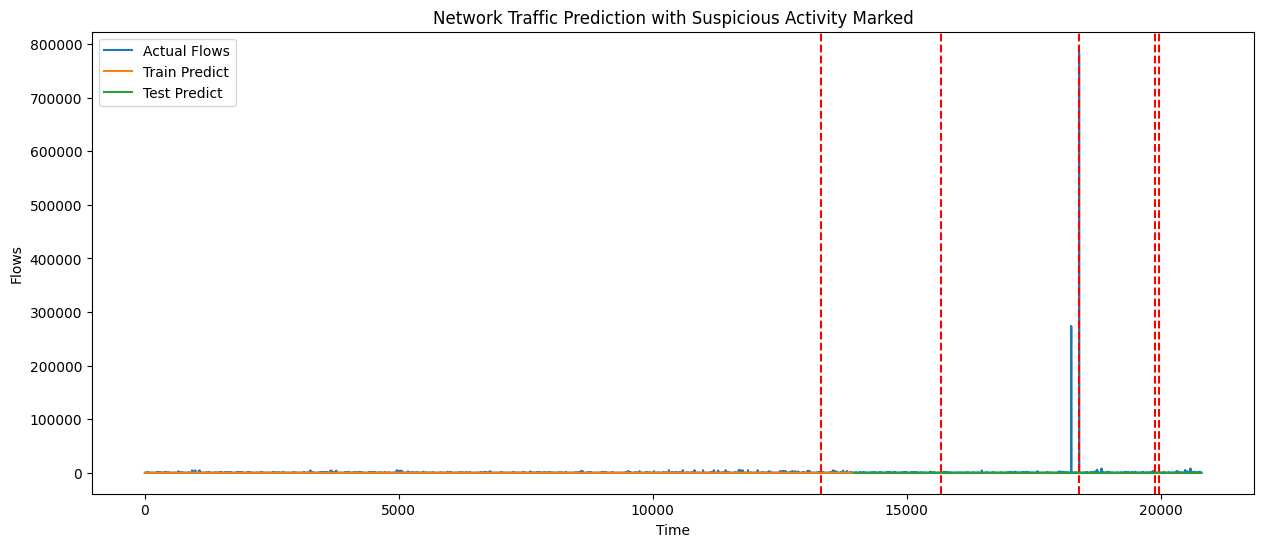

In [12]:
# Plot the results
plt.figure(figsize=(15, 6))
plt.plot(df['f'], label='Actual Flows')

# Mark suspicious activity dates on the plot
for date, ips in suspicious_activity.items():
    if isinstance(ips, list):
        for ip in ips:
            plt.axvline(x=df[(df['date'] == date) & (df['l_ipn'] == ip)].index[0], color='r', linestyle='--')
    else:
        plt.axvline(x=df[(df['date'] == date) & (df['l_ipn'] == ips)].index[0], color='r', linestyle='--')

# Initialize prediction plots with NaN values
train_predict_plot = np.empty(len(df['f']))
train_predict_plot[:] = np.nan
train_predict_plot[time_step:len(train_predict) + time_step] = train_predict[:, 0]

test_predict_plot = np.empty(len(df['f']))
test_predict_plot[:] = np.nan
test_predict_plot[len(train_predict) + (time_step * 2) + 1:len(df['f'])] = test_predict[:len(df['f']) - (len(train_predict) + (time_step * 2) + 1), 0]

# Plot predictions
plt.plot(train_predict_plot, label='Train Predict')
plt.plot(test_predict_plot, label='Test Predict')

plt.title('Network Traffic Prediction with Suspicious Activity Marked')
plt.xlabel('Time')
plt.ylabel('Flows')
plt.legend()
plt.show()
